In [4]:
import numpy as np

import torch
import torch.utils.data

import matplotlib.pyplot as plt

import datasets
import metaimage
import nnet
import voxgrid
import display

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset generation

The dataset used for this prototype is a synthetic dataset consisting of masks a 16x16x16 cube centered in a 32x32x32 space, with the masks generated from random angles around the cube.

This is intended as a simple test to identify if a basic, consistent 3D shape can be recovered from a collection of masks.

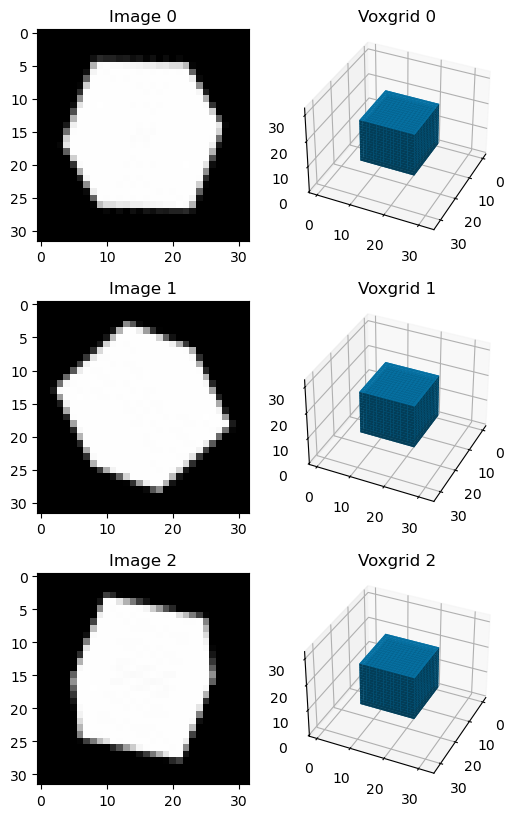

In [5]:
SIDE_RANGE = (16, 16)
IMAGE_SIZE = (32, 32)
SPACE_SIZE = (32, 32, 32)
BATCH_SIZE = 100

train_dataset_0_noise = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 1000, train=True)
val_dataset_0_noise = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 100)

train_loader_0_noise = torch.utils.data.DataLoader(
    train_dataset_0_noise, batch_size=BATCH_SIZE, shuffle=True
)
val_loader_0_noise = torch.utils.data.DataLoader(val_dataset_0_noise, batch_size=BATCH_SIZE)

display.grid(
    [
        [
            metaimage.Mask(train_dataset_0_noise[i][0], title=f"Image {i}"),
            voxgrid.VoxGrid(train_dataset_0_noise[i][1][1], title=f"Voxgrid {i}"),
        ]
        for i in range(3)
    ],
    figsize=(6, 10),
)
display.show()

## GAN

To recover the shape, a GAN is used.

### Generator

The generator is a 3D convolutional network. The latent space is mapped linearly to a 128x2x2x2 tensor. This is then repeatedly upsampled using convolutional layer followed by a strided transpose convolution. This doubles the dimensions and halves the number of channels at each stage, to reach a 8x32x32x32 tensor. A final convolutional layer is used produce a 1x32x32x32 tensor.

This tensor can then be returned, to provide a voxel representation, or a mask is created from a random angle around the cube to produce a 32x32 mask.

### Discriminator

The discriminator is a 2D resnet. This takes in a 32x32 mask, passes it through a resnet block and downsample using a strided convolution, halving the dimensions and doubling the number of channels at each stage. This is until a 4x4 mask is produced, which is then flattened and passed through a linear layer to produce a single label indicating the probability that the mask is real.

In [6]:
LATENT_SIZE = 256
BASE_CHANNELS = 12
DISCRIMINATOR_CHANNELS = 8
FOREGROUND_CHANNELS = 8
ACTIVATION = torch.nn.LeakyReLU

DISCRIMINATOR_DROPOUT = 0.1
GENERATOR_DROPOUT = 0.1

DEVICE = torch.device("cuda:0")

def create_nnets():
    discriminator = torch.nn.Sequential(
        nnet.blocks.conv.BasicConvBlock(
            in_channels=1,
            out_channels=DISCRIMINATOR_CHANNELS,
            kernel_size=1,
            activation=ACTIVATION,
        ),
        nnet.blocks.conv.ResizeStack(
            in_shape=(DISCRIMINATOR_CHANNELS, IMAGE_SIZE[0], IMAGE_SIZE[1]),
            out_shape=(DISCRIMINATOR_CHANNELS * IMAGE_SIZE[0] // 2, 2, 2),
            layer_factory=nnet.blocks.resnet.create_resnet_2d_factory(
                stochastic_depth_rate=DISCRIMINATOR_DROPOUT,
                activation=ACTIVATION,
                dropout=DISCRIMINATOR_DROPOUT,
            ),
            resize_factory=nnet.blocks.conv.create_strided_downsample_factory(
                activation=ACTIVATION,
                dropout=DISCRIMINATOR_DROPOUT,
            ),
            layer_factories_per_downsample=0,
        ),
        nnet.blocks.conv.ConvToLinear(
            (DISCRIMINATOR_CHANNELS * IMAGE_SIZE[0] // 2, 2, 2),
            out_dim=1,
            activation=torch.nn.Sigmoid,
        ),
    )

    voxel_generator = torch.nn.Sequential(
        nnet.blocks.conv.LinearToConv(
            in_dim=LATENT_SIZE,
            out_shape=(BASE_CHANNELS * SPACE_SIZE[0] // 2, 2, 2, 2),
            activation=ACTIVATION,
        ),
        nnet.blocks.conv.ResizeStack(
            in_shape=(BASE_CHANNELS * SPACE_SIZE[0] // 2, 2, 2, 2),
            out_shape=(BASE_CHANNELS, SPACE_SIZE[0], SPACE_SIZE[1], SPACE_SIZE[2]),
            layer_factory=nnet.blocks.conv.create_basic_conv_factory(
                activation=ACTIVATION,
                dropout=GENERATOR_DROPOUT,
                use_3d=True,
            ),
            resize_factory=nnet.blocks.conv.create_upsample_block_factory(
                use_3d=True,
                activation=ACTIVATION,
                dropout=GENERATOR_DROPOUT,
            ),
            layer_factories_per_downsample=0,
        ),
        nnet.blocks.conv.BasicConvBlock(
            use_3d=True,
            in_channels=BASE_CHANNELS,
            out_channels=1,
            activation=torch.nn.Sigmoid,
            kernel_size=1,
            use_batch_norm=False,
        ),
        nnet.modules.VoxGridAlphaAdjust()
    )

    foreground_generator = torch.nn.Sequential(
        nnet.blocks.conv.LinearToConv(
            in_dim=LATENT_SIZE,
            out_shape=(FOREGROUND_CHANNELS * SPACE_SIZE[0], 1, 1),
            activation=ACTIVATION,
        ),
        nnet.blocks.conv.ResizeStack(
            in_shape=(FOREGROUND_CHANNELS * SPACE_SIZE[0], 1, 1),
            out_shape=(FOREGROUND_CHANNELS, SPACE_SIZE[0], SPACE_SIZE[1]),
            layer_factory=nnet.blocks.conv.create_basic_conv_factory(
                activation=ACTIVATION,
                dropout=GENERATOR_DROPOUT,
            ),
            resize_factory=nnet.blocks.conv.create_upsample_block_factory(
                activation=ACTIVATION,
                dropout=GENERATOR_DROPOUT,
            ),
            layer_factories_per_downsample=0,
        ),
        nnet.blocks.conv.BasicConvBlock(
            in_channels=FOREGROUND_CHANNELS,
            out_channels=FOREGROUND_CHANNELS,
            activation=ACTIVATION,
            kernel_size=5,
        ),
        nnet.blocks.conv.BasicConvBlock(
            in_channels=FOREGROUND_CHANNELS,
            out_channels=2,
            activation=torch.nn.Sigmoid,
            kernel_size=1,
            use_batch_norm=False,
        )
    )

    mask_generator = nnet.generators.MaskGenerator(
        model_gen = voxel_generator,
        device = DEVICE,
        foreground_gen=foreground_generator,
    )

    return voxel_generator, mask_generator, discriminator

vox_gen_0_noise, mask_gen_0_noise, discriminator_0_noise = create_nnets()

gan_trainer_0_noise = nnet.training.GANTrainer(
    mask_gen_0_noise,
    discriminator_0_noise,
    means=np.zeros(LATENT_SIZE),
    stds=np.ones(LATENT_SIZE),
    lr_gen=1e-3,
    lr_disc=1e-4,
)

model_path = "models/cube_gan"
bookmark_interval = 50

print(mask_gen_0_noise)
print(discriminator_0_noise)

MaskGenerator(
  (model_gen): Sequential(
    (0): LinearToConv(
      (main): Sequential(
        (0): Linear(in_features=256, out_features=1536, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Unflatten(dim=1, unflattened_size=(192, 2, 2, 2))
      )
    )
    (1): ResizeStack(
      (main): Sequential(
        (0): UpsampleBlock(
          (conv): Sequential(
            (0): Upsample(scale_factor=2.0, mode='nearest')
            (1): Conv3d(192, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (2): BatchNorm3d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): LeakyReLU(negative_slope=0.01)
            (4): Dropout3d(p=0.1, inplace=False)
          )
        )
        (1): UpsampleBlock(
          (conv): Sequential(
            (0): Upsample(scale_factor=2.0, mode='nearest')
            (1): Conv3d(96, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (2): BatchNorm3d(48, eps

In [15]:
gan_trainer_0_noise.train(
    train_loader_0_noise,
    val_loader_0_noise,
    epochs=50,
    path=model_path,
    noise=0.15,
    gen_train_thresh=1.5,
    dis_train_thresh=1.25,
    device=DEVICE,
    bookmark_every=bookmark_interval,
)

Epoch 50/50 | val loss (gen/dis): 0.9429/4.9011 | train loss: 0.75(50)/1.35(50): 100%|██████████| 50/50 [02:15<00:00,  2.71s/it]


Model models/cube_gan_50.pt is loaded from epoch 50 , loss 0.9429


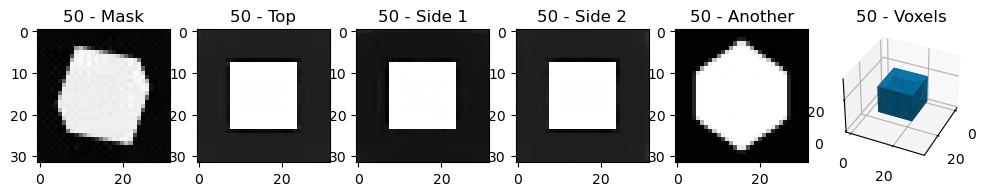

In [16]:
START_MODEL = 50
END_MODEL = 50

models = list(range(START_MODEL, END_MODEL + 1, bookmark_interval))

vox_gen_0_noise.eval()
mask_gen_0_noise.eval()
mask_gen_0_noise.to(DEVICE)

gen_input = torch.Tensor(np.random.normal(0, 1, size=(2, LATENT_SIZE))).cuda()

plot_grid = []

for model_n in models:
    gan_trainer_0_noise.load_state(f"{model_path}_{model_n}.pt")
    
    mask_out = mask_gen_0_noise(gen_input)[0]

    mask = metaimage.Mask(
        mask_out, title=f"{model_n} - Mask"
    )
    voxels = voxgrid.VoxGrid(
        vox_gen_0_noise(gen_input)[0], title=f"{model_n} - Voxels"
    )

    plot_grid.append(
        [
            mask,
            (f"{model_n} - Top", voxels.create_image()),
            (f"{model_n} - Side 1", voxels.rotated(y_angle=np.pi / 2).create_image()),
            (f"{model_n} - Side 2", voxels.rotated(z_angle=np.pi / 2).create_image()),
            (f"{model_n} - Another", voxels.rotated(z_angle=np.pi / 4, y_angle=np.pi/4).create_image()),
            voxels,
        ]
    )

display.grid(plot_grid, figsize=(12, 3 * len(plot_grid)))
display.show()

Model models/cube_gan_50.pt is loaded from epoch 50 , loss 0.9429


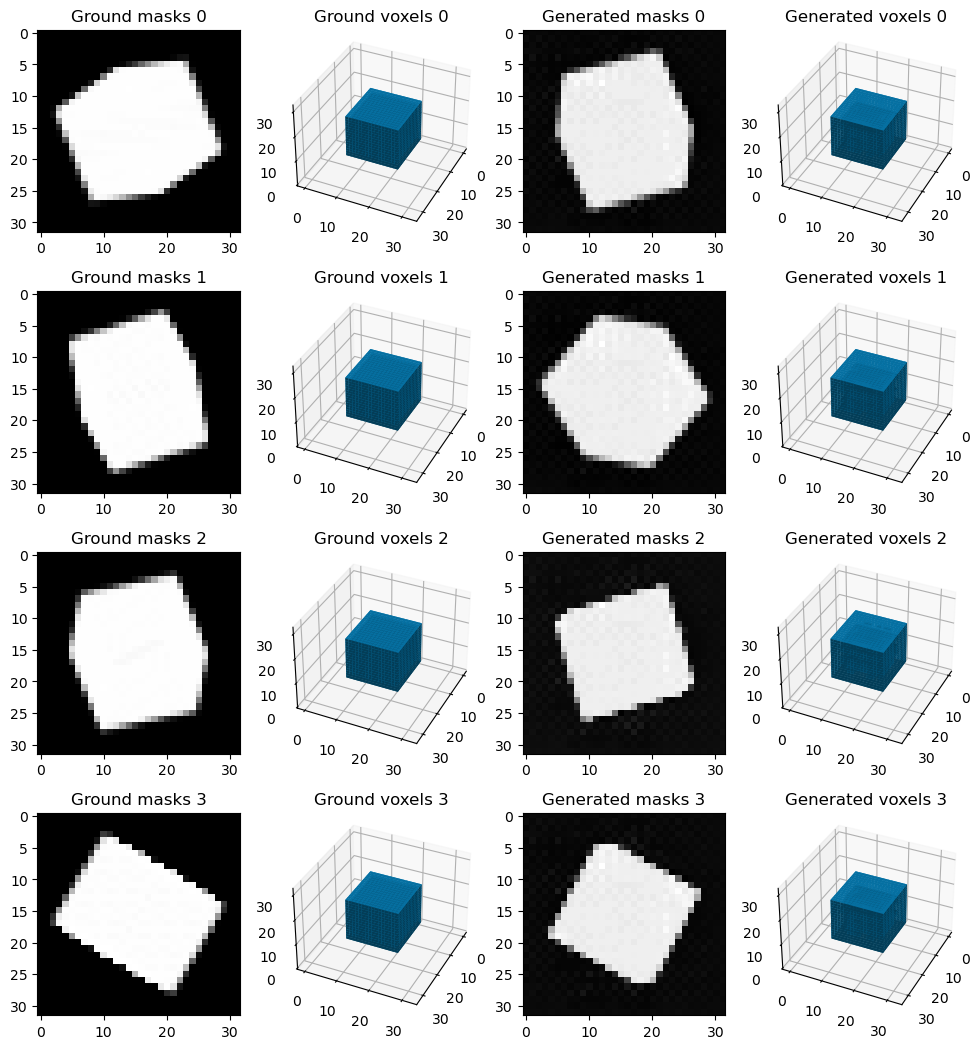

In [17]:
MODEL = 50

gan_trainer_0_noise.load_state(f"{model_path}_{MODEL}.pt")

gen_input = torch.Tensor(np.random.normal(0, 1, size=(4, LATENT_SIZE))).cuda()

masks = mask_gen_0_noise(gen_input)[:4]
voxels = vox_gen_0_noise(gen_input)[:4]

plot_grid = []

for i in range(4):
    cur_voxels = voxgrid.VoxGrid(voxels[i], title=f"Generated voxels {i}")
    cur_mask = metaimage.Mask(masks[i], title=f"Generated masks {i}")
    ground_mask, ground_voxels = train_dataset_0_noise[i][1]
    ground_mask = metaimage.Mask(ground_mask, title=f"Ground masks {i}")
    ground_voxels = voxgrid.VoxGrid(
        ground_voxels, title=f"Ground voxels {i}"
    )

    plot_grid.append([ground_mask, ground_voxels, cur_mask, cur_voxels])

display.grid(plot_grid, figsize=(12, 13))
display.show()

## Noise

The following tests how resilient the method is to adding salt and pepper noise to the training data.

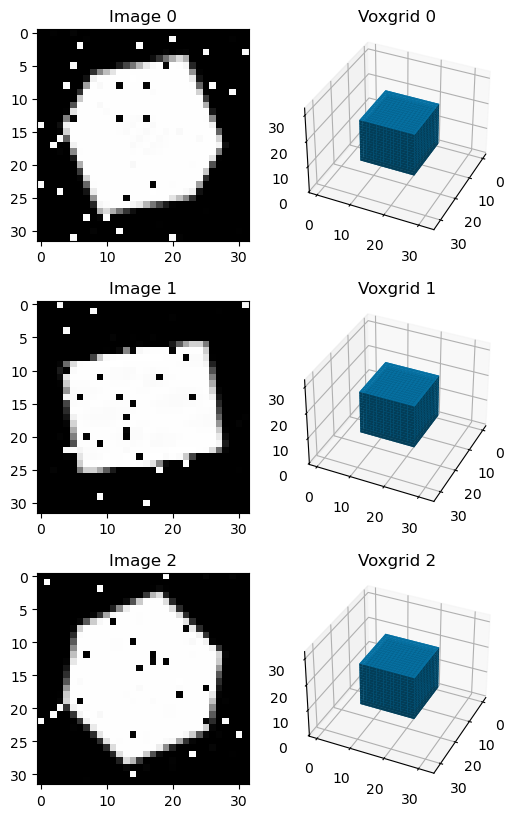

In [4]:

train_dataset_5_noise = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 1000, train=True, noise=0.05)
val_dataset_5_noise = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 100, noise=0.05)

train_loader_5_noise = torch.utils.data.DataLoader(
    train_dataset_5_noise, batch_size=BATCH_SIZE, shuffle=True
)
val_loader_5_noise = torch.utils.data.DataLoader(val_dataset_5_noise, batch_size=BATCH_SIZE)

display.grid(
    [
        [
            metaimage.Mask(train_dataset_5_noise[i][0], title=f"Image {i}"),
            voxgrid.VoxGrid(train_dataset_5_noise[i][1][1], title=f"Voxgrid {i}"),
        ]
        for i in range(3)
    ],
    figsize=(6, 10),
)
display.show()

In [5]:
vox_gen_5_noise, mask_gen_5_noise, discriminator_5_noise = create_nnets()

gan_trainer_5_noise = nnet.training.GANTrainer(
    mask_gen_5_noise,
    discriminator_5_noise,
    means=np.zeros(LATENT_SIZE),
    stds=np.ones(LATENT_SIZE),
    lr_gen=1e-3,
    lr_disc=1e-4,
)

model_path = "models/cube_gan_5_noise"
bookmark_interval = 50

In [33]:
gan_trainer_5_noise.train(
    train_loader_5_noise,
    val_loader_5_noise,
    epochs=200,
    path=model_path,
    noise=0.15,
    gen_train_thresh=1.5,
    dis_train_thresh=1.25,
    device=DEVICE,
    bookmark_every=bookmark_interval,
)

Epoch 200/200 | val loss (gen/dis): 2.1592/0.9186 | train loss: 0.87(192)/1.03(140): 100%|██████████| 200/200 [08:16<00:00,  2.48s/it]


Model models/cube_gan_5_noise_50.pt is loaded from epoch 50 , loss 2.6838
Model models/cube_gan_5_noise_100.pt is loaded from epoch 100 , loss 2.9882
Model models/cube_gan_5_noise_150.pt is loaded from epoch 150 , loss 0.8349
Model models/cube_gan_5_noise_200.pt is loaded from epoch 200 , loss 2.1592


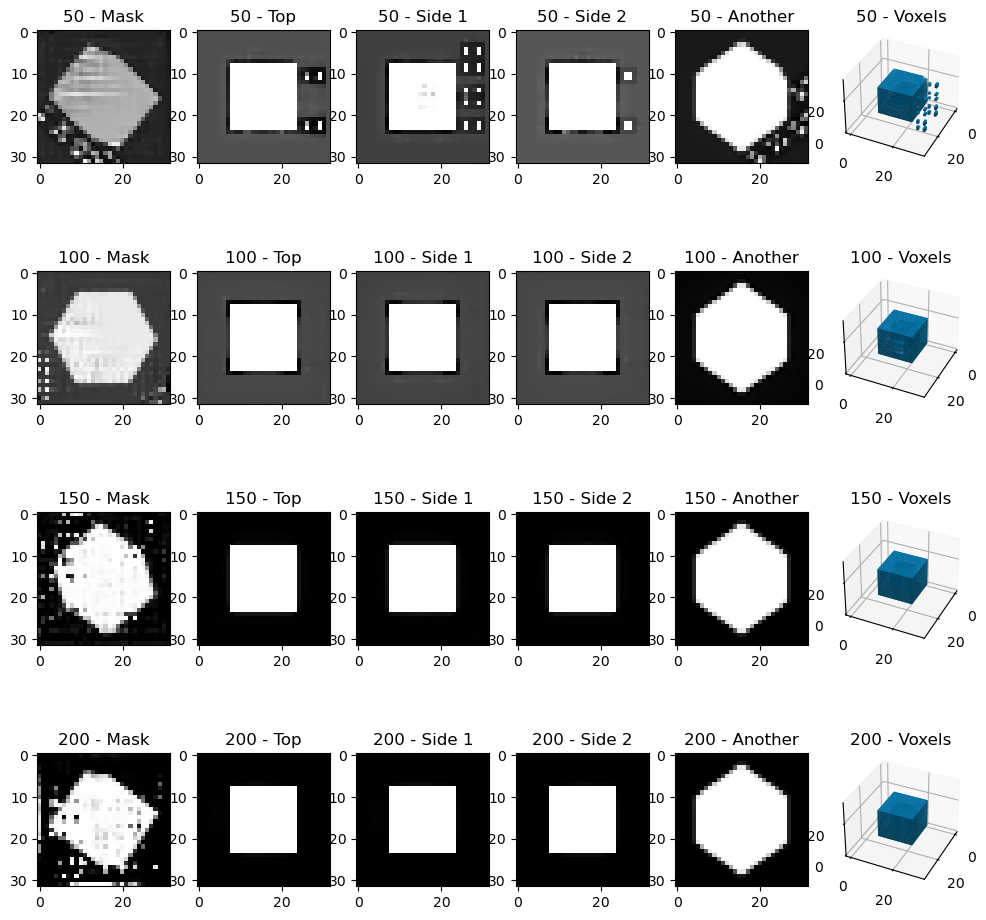

In [34]:
START_MODEL = 50
END_MODEL = 200

models = list(range(START_MODEL, END_MODEL + 1, bookmark_interval))

vox_gen_5_noise.eval()
mask_gen_5_noise.eval()
mask_gen_5_noise.to(DEVICE)

gen_input = torch.Tensor(np.random.normal(0, 1, size=(2, LATENT_SIZE))).cuda()

plot_grid = []

for model_n in models:
    gan_trainer_5_noise.load_state(f"{model_path}_{model_n}.pt")
    
    mask_out = mask_gen_5_noise(gen_input)[0]

    mask = metaimage.Mask(
        mask_out, title=f"{model_n} - Mask"
    )
    voxels = voxgrid.VoxGrid(
        vox_gen_5_noise(gen_input)[0], title=f"{model_n} - Voxels"
    )

    plot_grid.append(
        [
            mask,
            (f"{model_n} - Top", voxels.create_image()),
            (f"{model_n} - Side 1", voxels.rotated(y_angle=np.pi / 2).create_image()),
            (f"{model_n} - Side 2", voxels.rotated(z_angle=np.pi / 2).create_image()),
            (f"{model_n} - Another", voxels.rotated(z_angle=np.pi / 4, y_angle=np.pi/4).create_image()),
            voxels,
        ]
    )

display.grid(plot_grid, figsize=(12, 3 * len(plot_grid)))
display.show()

Model models/cube_gan_5_noise_150.pt is loaded from epoch 150 , loss 0.8349


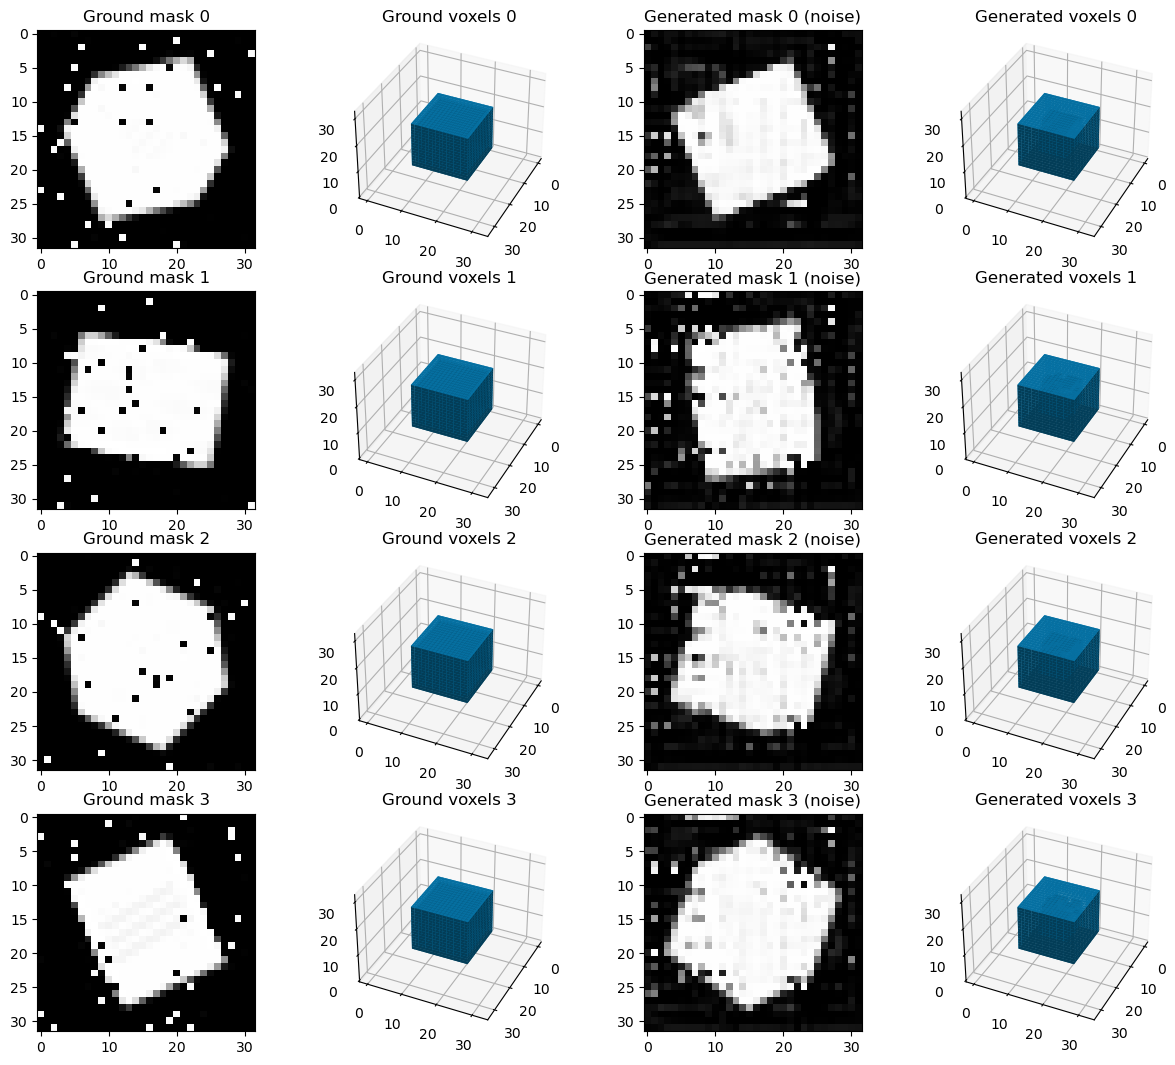

In [6]:
MODEL = 150

gan_trainer_5_noise.load_state(f"{model_path}_{MODEL}.pt")

gen_input = torch.Tensor(np.random.normal(0, 1, size=(4, LATENT_SIZE))).cuda()

masks = mask_gen_5_noise(gen_input)[:4]
voxels = vox_gen_5_noise(gen_input)[:4]

plot_grid = []

for i in range(4):
    cur_voxels = voxgrid.VoxGrid(voxels[i], title=f"Generated voxels {i}")
    rot_mask = cur_voxels.rotated(*np.random.uniform(0, np.pi*2, size=3)).create_image()
    rot_mask.title = f"Generated mask {i} (no noise)"
    cur_mask = metaimage.Mask(masks[i], title=f"Generated mask {i} (noise)")
    ground_mask, ground_voxels = train_dataset_5_noise[i][1]
    ground_mask = metaimage.Mask(ground_mask, title=f"Ground mask {i}")
    ground_voxels = voxgrid.VoxGrid(
        ground_voxels, title=f"Ground voxels {i}"
    )

    plot_grid.append([ground_mask, ground_voxels, cur_mask, cur_voxels])

display.grid(plot_grid, figsize=(15, 13))
display.show()

### 15% noise

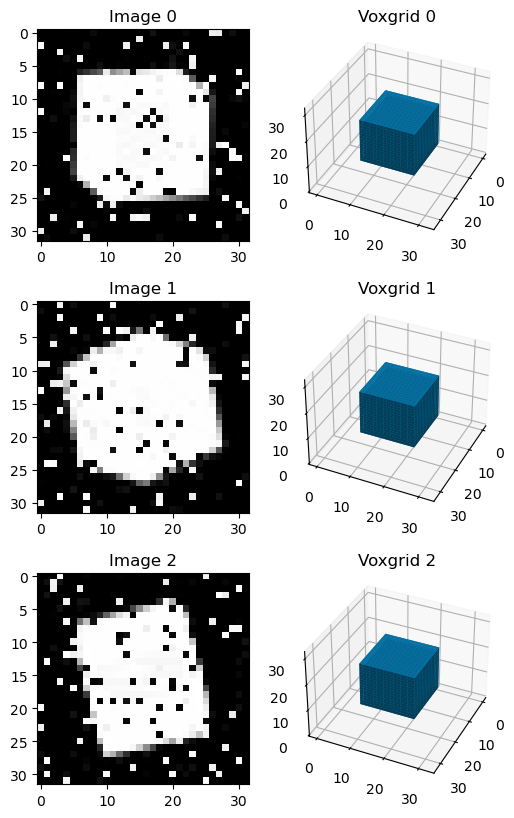

In [7]:

train_dataset_15_noise = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 1000, train=True, noise=0.15)
val_dataset_15_noise = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 100, noise=0.15)

train_loader_15_noise = torch.utils.data.DataLoader(
    train_dataset_15_noise, batch_size=BATCH_SIZE, shuffle=True
)
val_loader_15_noise = torch.utils.data.DataLoader(val_dataset_15_noise, batch_size=BATCH_SIZE)

display.grid(
    [
        [
            metaimage.Mask(train_dataset_15_noise[i][0], title=f"Image {i}"),
            voxgrid.VoxGrid(train_dataset_15_noise[i][1][1], title=f"Voxgrid {i}"),
        ]
        for i in range(3)
    ],
    figsize=(6, 10),
)
display.show()

In [8]:
vox_gen_15_noise, mask_gen_15_noise, discriminator_15_noise = create_nnets()

gan_trainer_15_noise = nnet.training.GANTrainer(
    mask_gen_15_noise,
    discriminator_15_noise,
    means=np.zeros(LATENT_SIZE),
    stds=np.ones(LATENT_SIZE),
    lr_gen=1e-3,
    lr_disc=1e-4,
)

model_path = "models/cube_gan_15_noise"
bookmark_interval = 50

In [38]:
gan_trainer_15_noise.train(
    train_loader_15_noise,
    val_dataset_15_noise,
    epochs=200,
    path=model_path,
    noise=0.15,
    gen_train_thresh=1.5,
    dis_train_thresh=1.25,
    device=DEVICE,
    bookmark_every=bookmark_interval,
)

Epoch 200/200 | val loss (gen/dis): 0.7119/1.3803 | train loss: 1.32(197)/1.09(124): 100%|██████████| 200/200 [08:23<00:00,  2.52s/it]


Model models/cube_gan_15_noise_50.pt is loaded from epoch 50 , loss 0.2900
Model models/cube_gan_15_noise_100.pt is loaded from epoch 100 , loss 0.3814
Model models/cube_gan_15_noise_150.pt is loaded from epoch 150 , loss 0.4258
Model models/cube_gan_15_noise_200.pt is loaded from epoch 200 , loss 0.7119


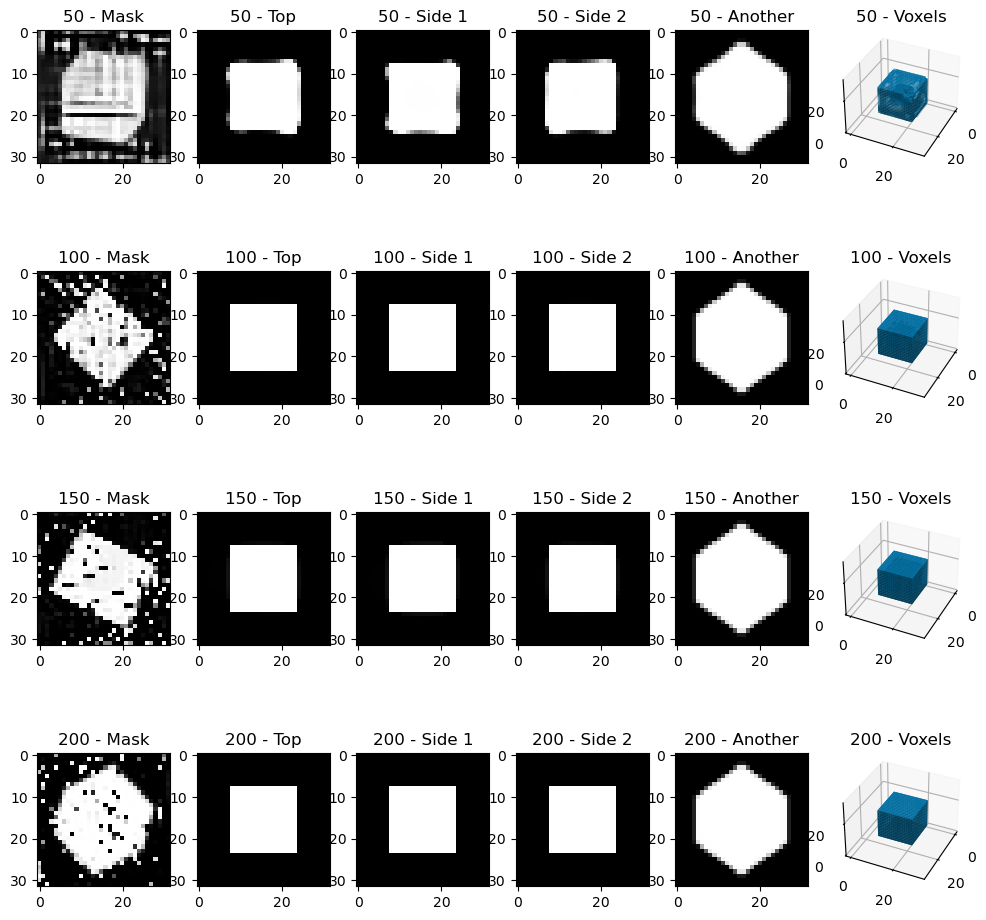

In [39]:
START_MODEL = 50
END_MODEL = 200

models = list(range(START_MODEL, END_MODEL + 1, bookmark_interval))

vox_gen_15_noise.eval()
mask_gen_15_noise.eval()
mask_gen_15_noise.to(DEVICE)

gen_input = torch.Tensor(np.random.normal(0, 1, size=(2, LATENT_SIZE))).cuda()

plot_grid = []

for model_n in models:
    gan_trainer_15_noise.load_state(f"{model_path}_{model_n}.pt")
    
    mask_out = mask_gen_15_noise(gen_input)[0]

    mask = metaimage.Mask(
        mask_out, title=f"{model_n} - Mask"
    )
    voxels = voxgrid.VoxGrid(
        vox_gen_15_noise(gen_input)[0], title=f"{model_n} - Voxels"
    )

    plot_grid.append(
        [
            mask,
            (f"{model_n} - Top", voxels.create_image()),
            (f"{model_n} - Side 1", voxels.rotated(y_angle=np.pi / 2).create_image()),
            (f"{model_n} - Side 2", voxels.rotated(z_angle=np.pi / 2).create_image()),
            (f"{model_n} - Another", voxels.rotated(z_angle=np.pi / 4, y_angle=np.pi/4).create_image()),
            voxels,
        ]
    )

display.grid(plot_grid, figsize=(12, 3 * len(plot_grid)))
display.show()

Model models/cube_gan_15_noise_200.pt is loaded from epoch 200 , loss 0.7119


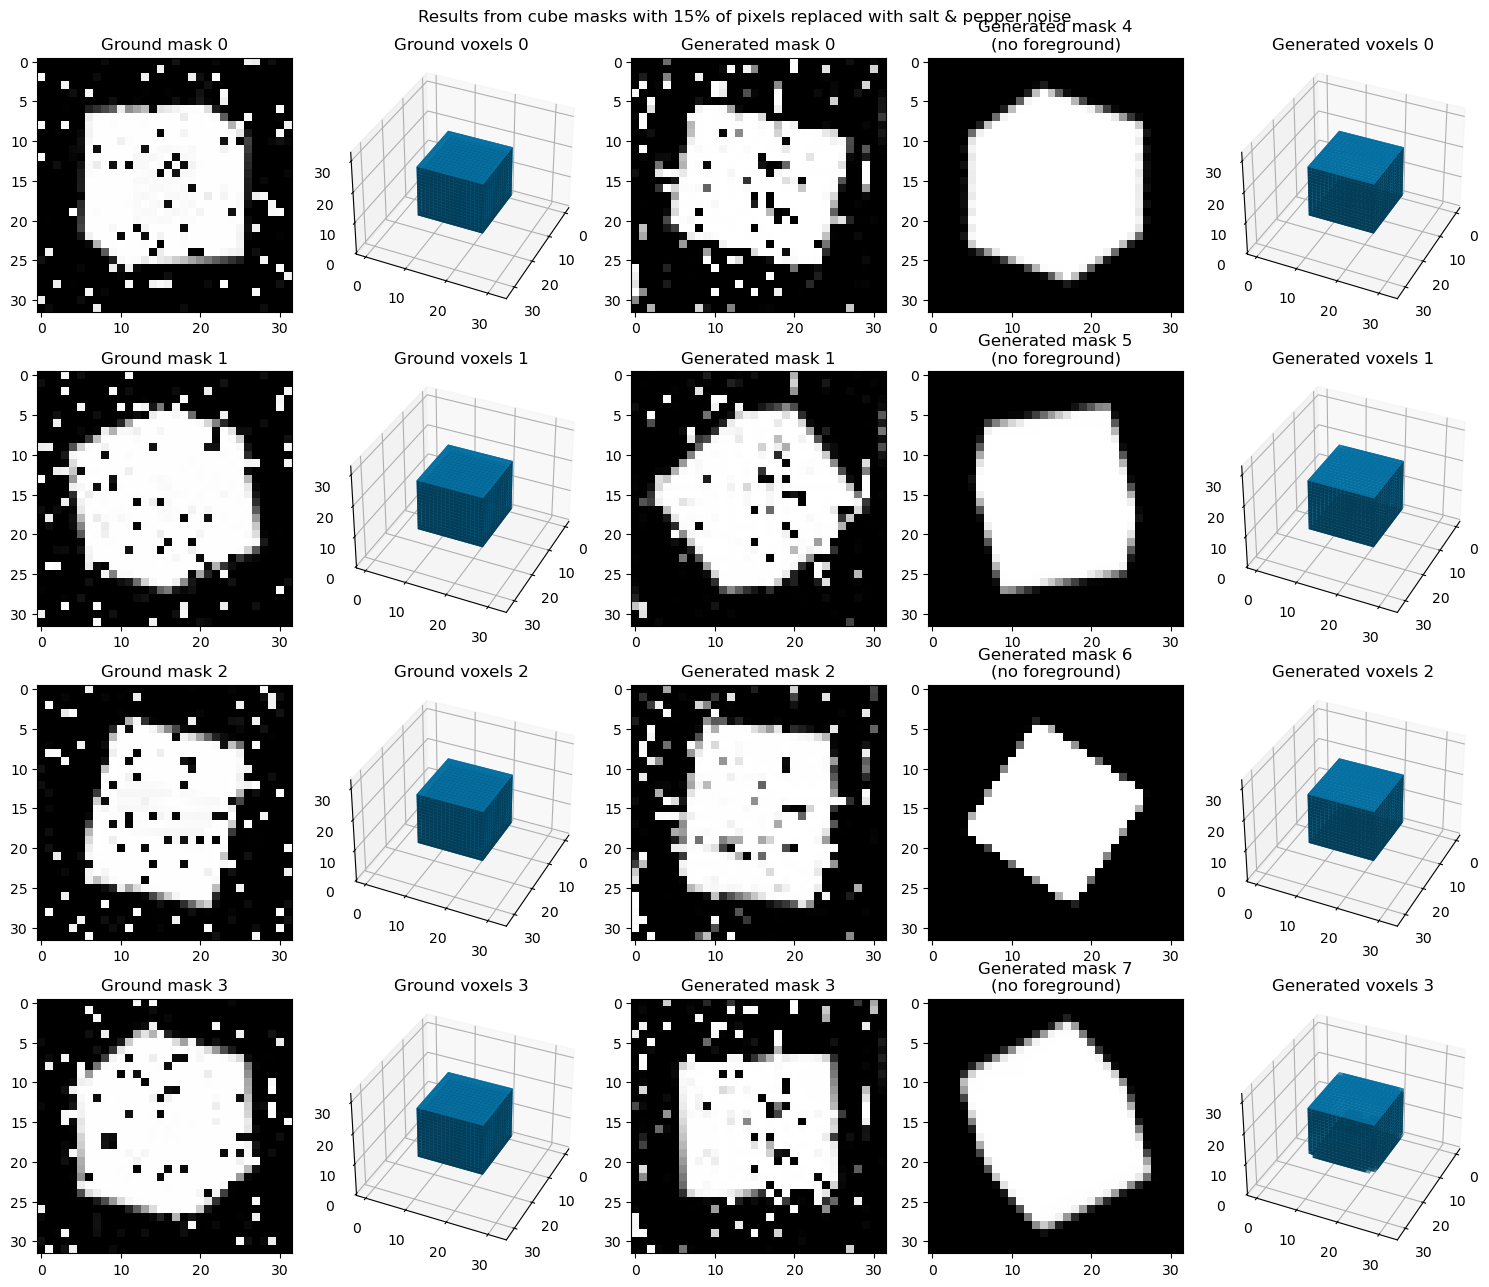

In [13]:
MODEL = 200

gan_trainer_15_noise.load_state(f"{model_path}_{MODEL}.pt")

gen_input = torch.Tensor(np.random.normal(0, 1, size=(4, LATENT_SIZE))).cuda()

masks = mask_gen_15_noise(gen_input)[:4]
voxels = vox_gen_15_noise(gen_input)[:4]

plot_grid = []

for i in range(4):
    cur_voxels = voxgrid.VoxGrid(voxels[i], title=f"Generated voxels {i}")
    rot_mask = cur_voxels.rotated(*np.random.uniform(0, np.pi*2, size=3)).create_image()
    rot_mask.title = f"Generated mask {i+4}\n(no foreground)"
    cur_mask = metaimage.Mask(masks[i], title=f"Generated mask {i}")
    ground_mask, ground_voxels = train_dataset_15_noise[i][1]
    ground_mask = metaimage.Mask(ground_mask, title=f"Ground mask {i}")
    ground_voxels = voxgrid.VoxGrid(
        ground_voxels, title=f"Ground voxels {i}"
    )

    plot_grid.append([ground_mask, ground_voxels, cur_mask, rot_mask, cur_voxels])

display.grid(plot_grid, figsize=(15, 13), title="Results from cube masks with 15% of pixels replaced with salt & pepper noise")
display.show()

### 30% noise

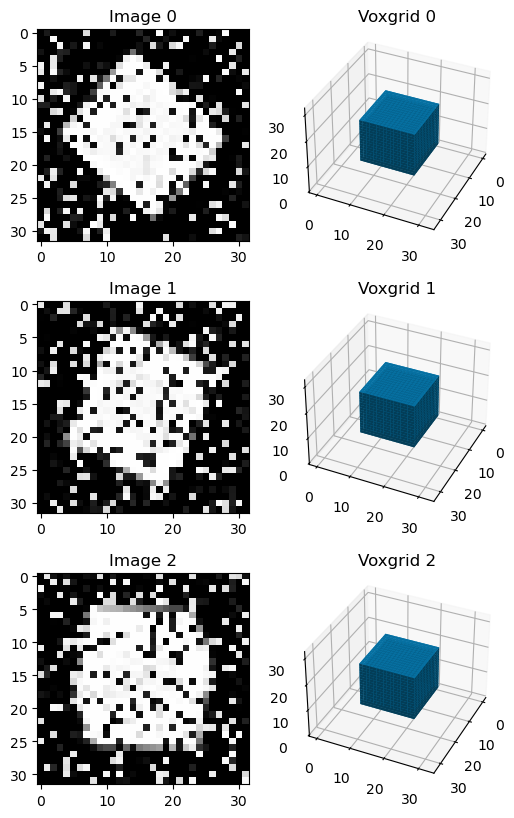

In [47]:

train_dataset_30_noise = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 1000, train=True, noise=0.30)
val_dataset_30_noise = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 100, noise=0.30)

train_loader_30_noise = torch.utils.data.DataLoader(
    train_dataset_30_noise, batch_size=BATCH_SIZE, shuffle=True
)
val_loader_30_noise = torch.utils.data.DataLoader(val_dataset_30_noise, batch_size=BATCH_SIZE)

display.grid(
    [
        [
            metaimage.Mask(train_dataset_30_noise[i][0], title=f"Image {i}"),
            voxgrid.VoxGrid(train_dataset_30_noise[i][1][1], title=f"Voxgrid {i}"),
        ]
        for i in range(3)
    ],
    figsize=(6, 10),
)
display.show()

In [59]:
vox_gen_30_noise, mask_gen_30_noise, discriminator_30_noise = create_nnets()

gan_trainer_30_noise = nnet.training.GANTrainer(
    mask_gen_30_noise,
    discriminator_30_noise,
    means=np.zeros(LATENT_SIZE),
    stds=np.ones(LATENT_SIZE),
    lr_gen=1e-3,
    lr_disc=1e-4,
)

model_path = "models/cube_gan_30_noise"
bookmark_interval = 100

In [71]:
gan_trainer_30_noise.train(
    train_loader_30_noise,
    val_loader_30_noise,
    epochs=100,
    path=model_path,
    noise=0.15,
    gen_train_thresh=1.5,
    dis_train_thresh=1.25,
    device=DEVICE,
    bookmark_every=bookmark_interval,
)

Epoch 600/600 | val loss (gen/dis): 0.7870/14.3524 | train loss: 1.76(99)/0.60(39): 100%|██████████| 100/100 [04:24<00:00,  2.65s/it]


Model models/cube_gan_30_noise_300.pt is loaded from epoch 300 , loss 6.1050
Model models/cube_gan_30_noise_400.pt is loaded from epoch 400 , loss 1.2331
Model models/cube_gan_30_noise_500.pt is loaded from epoch 500 , loss 7.2941
Model models/cube_gan_30_noise_600.pt is loaded from epoch 600 , loss 0.7870


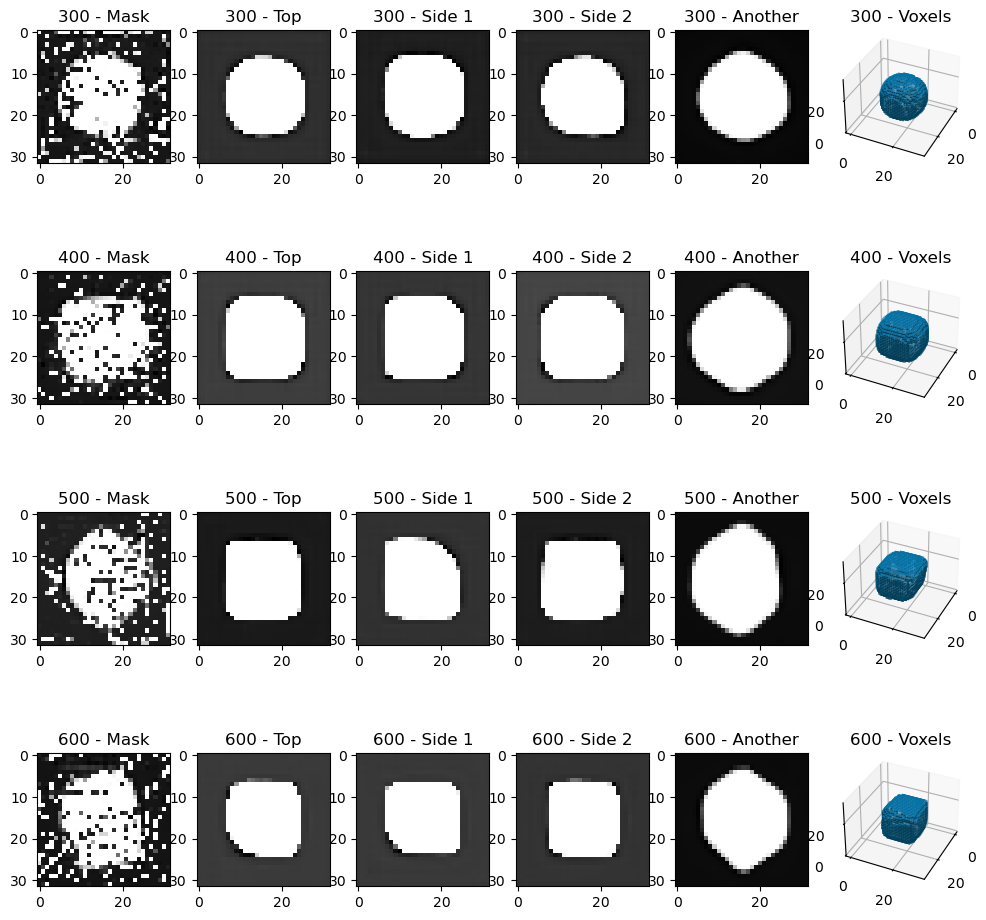

In [72]:
START_MODEL = 300
END_MODEL = 600

model_path = "models/cube_gan_30_noise"

models = list(range(START_MODEL, END_MODEL + 1, bookmark_interval))

vox_gen_30_noise.eval()
mask_gen_30_noise.eval()
mask_gen_30_noise.to(DEVICE)

gen_input = torch.Tensor(np.random.normal(0, 1, size=(2, LATENT_SIZE))).cuda()

plot_grid = []

for model_n in models:
    gan_trainer_30_noise.load_state(f"{model_path}_{model_n}.pt")
    
    mask_out = mask_gen_30_noise(gen_input)[0]

    mask = metaimage.Mask(
        mask_out, title=f"{model_n} - Mask"
    )
    voxels = voxgrid.VoxGrid(
        vox_gen_30_noise(gen_input)[0], title=f"{model_n} - Voxels"
    )

    plot_grid.append(
        [
            mask,
            (f"{model_n} - Top", voxels.create_image()),
            (f"{model_n} - Side 1", voxels.rotated(y_angle=np.pi / 2).create_image()),
            (f"{model_n} - Side 2", voxels.rotated(z_angle=np.pi / 2).create_image()),
            (f"{model_n} - Another", voxels.rotated(z_angle=np.pi / 4, y_angle=np.pi/4).create_image()),
            voxels,
        ]
    )

display.grid(plot_grid, figsize=(12, 3 * len(plot_grid)))
display.show()

### 50% Noise

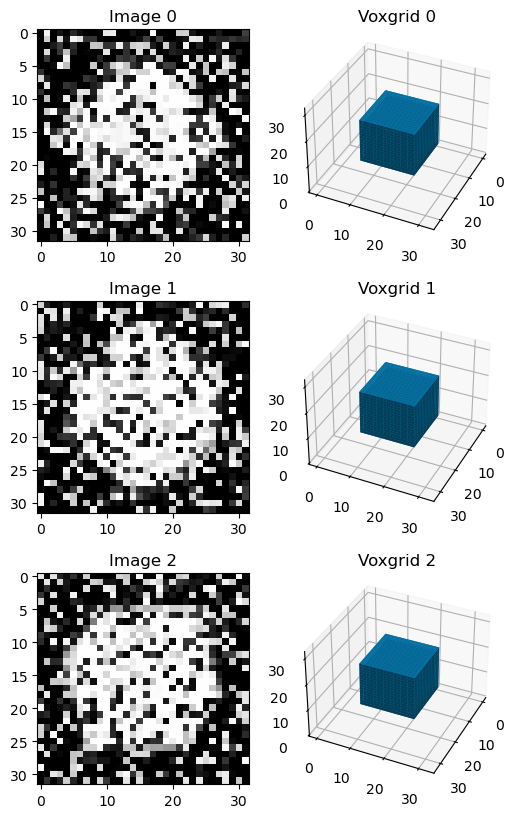

In [54]:

train_dataset_50_noise = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 1000, train=True, noise=0.50)
val_dataset_50_noise = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 100, noise=0.50)

train_loader_50_noise = torch.utils.data.DataLoader(
    train_dataset_50_noise, batch_size=BATCH_SIZE, shuffle=True
)
val_loader_50_noise = torch.utils.data.DataLoader(val_dataset_50_noise, batch_size=BATCH_SIZE)

display.grid(
    [
        [
            metaimage.Mask(train_dataset_50_noise[i][0], title=f"Image {i}"),
            voxgrid.VoxGrid(train_dataset_50_noise[i][1][1], title=f"Voxgrid {i}"),
        ]
        for i in range(3)
    ],
    figsize=(6, 10),
)
display.show()

In [62]:
vox_gen_50_noise, mask_gen_50_noise, discriminator_50_noise = create_nnets()

gan_trainer_50_noise = nnet.training.GANTrainer(
    mask_gen_50_noise,
    discriminator_50_noise,
    means=np.zeros(LATENT_SIZE),
    stds=np.ones(LATENT_SIZE),
    lr_gen=1e-3,
    lr_disc=1e-4,
)

model_path = "models/cube_gan_50_noise"
bookmark_interval = 100

In [63]:
gan_trainer_50_noise.train(
    train_loader_50_noise,
    val_loader_50_noise,
    epochs=500,
    path=model_path,
    noise=0.15,
    gen_train_thresh=1.5,
    dis_train_thresh=1.25,
    device=DEVICE,
    bookmark_every=bookmark_interval,
)

Epoch 500/500 | val loss (gen/dis): 18.1590/7.9321 | train loss: 1.51(474)/0.84(376): 100%|██████████| 500/500 [22:39<00:00,  2.72s/it] 


Model models/cube_gan_50_noise_100.pt is loaded from epoch 100 , loss 7.5025
Model models/cube_gan_50_noise_200.pt is loaded from epoch 200 , loss 3.1433
Model models/cube_gan_50_noise_300.pt is loaded from epoch 300 , loss 7.9650
Model models/cube_gan_50_noise_400.pt is loaded from epoch 400 , loss 28.1187
Model models/cube_gan_50_noise_500.pt is loaded from epoch 500 , loss 18.1590


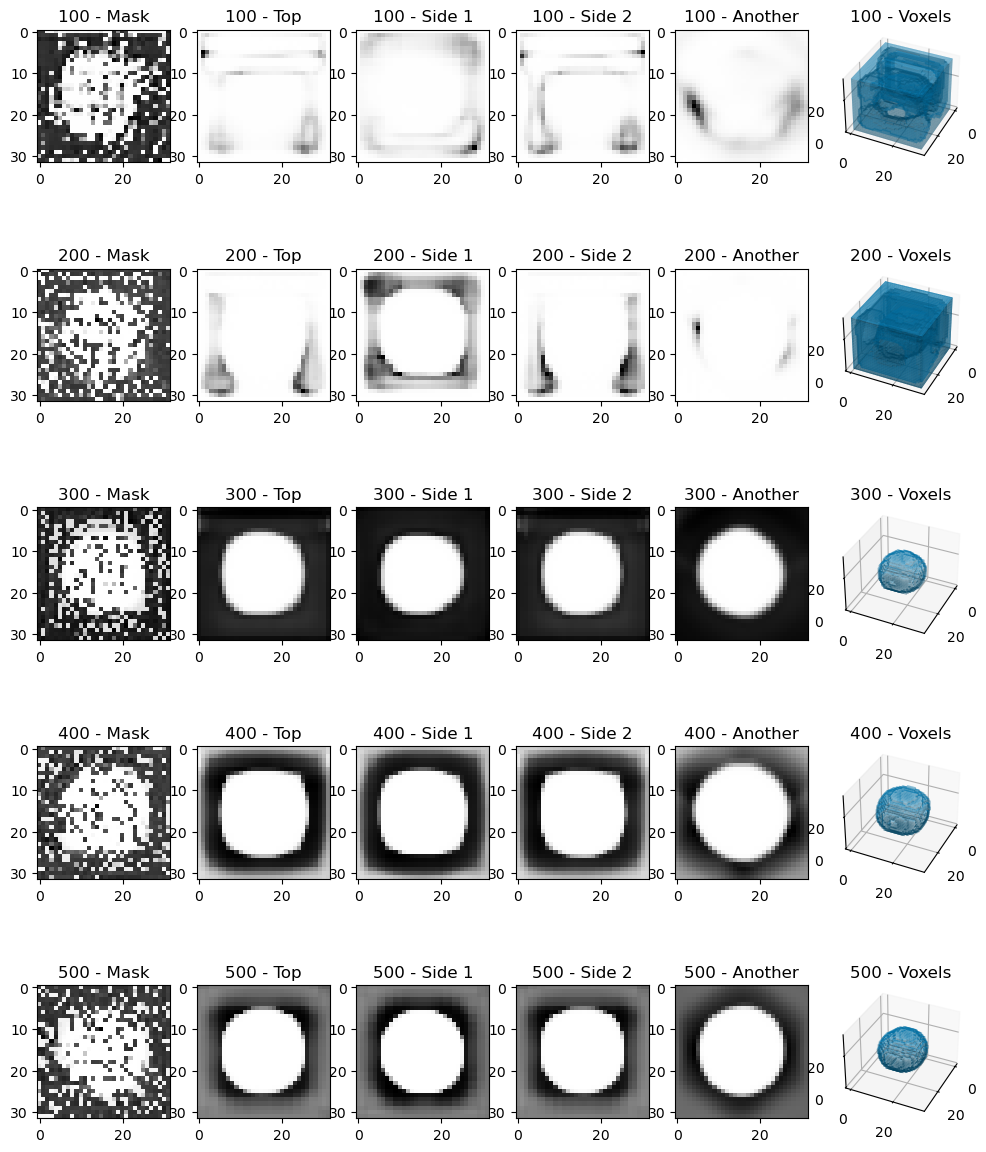

In [65]:
START_MODEL = 100
END_MODEL = 500

models = list(range(START_MODEL, END_MODEL + 1, bookmark_interval))

vox_gen_50_noise.eval()
mask_gen_50_noise.eval()
mask_gen_50_noise.to(DEVICE)

gen_input = torch.Tensor(np.random.normal(0, 1, size=(2, LATENT_SIZE))).cuda()

plot_grid = []

for model_n in models:
    gan_trainer_50_noise.load_state(f"{model_path}_{model_n}.pt")
    
    mask_out = mask_gen_50_noise(gen_input)[0]

    mask = metaimage.Mask(
        mask_out, title=f"{model_n} - Mask"
    )
    voxels = voxgrid.VoxGrid(
        vox_gen_50_noise(gen_input)[0], title=f"{model_n} - Voxels"
    )

    plot_grid.append(
        [
            mask,
            (f"{model_n} - Top", voxels.create_image()),
            (f"{model_n} - Side 1", voxels.rotated(y_angle=np.pi / 2).create_image()),
            (f"{model_n} - Side 2", voxels.rotated(z_angle=np.pi / 2).create_image()),
            (f"{model_n} - Another", voxels.rotated(z_angle=np.pi / 4, y_angle=np.pi/4).create_image()),
            voxels,
        ]
    )

display.grid(plot_grid, figsize=(12, 3 * len(plot_grid)))
display.show()